<a href="https://colab.research.google.com/github/grace12021/MATH-748-Final-Project/blob/main/progression2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Kaggle Library

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d andrewmvd/retinal-disease-classification
!unzip retinal-disease-classification.zip

100% 7.41G/7.43G [01:14<00:00, 75.0MB/s]
100% 7.43G/7.43G [01:14<00:00, 106MB/s] 


# Import Libraries

In [7]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tqdm import tqdm
from keras.preprocessing import image
pd.options.display.max_columns = 50

# Classification for Disease Detection

In [109]:
train_df = pd.read_csv('Training_Set/Training_Set/RFMiD_Training_Labels.csv')
val_df = pd.read_csv('Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df = pd.read_csv('Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

In [110]:
train_df['img_path'] = [f'Training_Set/Training_Set/Training/{id}.png' for id in train_df['ID']]
val_df['img_path'] = [f'Evaluation_Set/Evaluation_Set/Validation/{id}.png' for id in val_df['ID']]
test_df['img_path'] = [f'Test_Set/Test_Set/Test/{id}.png' for id in test_df['ID']]

In [112]:
train_df.columns

Index(['ID', 'Disease_Risk', 'img_path'], dtype='object')

In [160]:
type(train_df['Disease_Risk'][0])

numpy.int64

In [152]:
train_df = train_df[['Disease_Risk', 'img_path']]
val_df = val_df[['Disease_Risk', 'img_path']]
test_df = test_df[['Disease_Risk', 'img_path']]

In [153]:
Y_train = list(train_df.drop(['img_path'], axis=1).columns)
Y_val = list(val_df.drop(['img_path'], axis=1).columns)
Y_test = list(test_df.drop(['img_path'], axis=1).columns)

In [154]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [161]:
train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              x_col='img_path', 
                                              y_col=Y_train,
                                              target_size=(150,150),
                                              class_mode="raw",
                                              batch_size=16,
                                              shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df,
                                          x_col='img_path',
                                          y_col=Y_val,
                                          target_size=(150,150),
                                          class_mode="raw",
                                          batch_size=8)
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col=Y_test,
                                            target_size=(150,150),
                                            class_mode="raw")

Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


In [115]:
def D_CNet(inputs):
    # First convolution block
    x = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    d1_con = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    d1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d1_con)
    
    # Second convolution block
    d2 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d2_con = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d2_con)
    
    '''
    # Third convolution block
    d3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d3_con = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d3_con)
    
    # Fourth convolution block
    d4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d4_con = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d4_con)
    '''

    # Bottleneck layer
    b = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    b = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(b)
    
    # Flatten and output
    flat = tf.keras.layers.Flatten()(b)
    out = tf.keras.layers.Dense(units=1, activation='sigmoid')(flat)
    model = tf.keras.Model(inputs=[inputs], outputs=[out])
    return model

In [162]:
auc = tf.keras.metrics.AUC(multi_label=False,thresholds=[0,0.5])
inputs = tf.keras.layers.Input(shape=(150,150,3))
cnet = D_CNet(inputs)
cnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc])
cnet.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_140 (Conv2D)         (None, 150, 150, 8)       224       
                                                                 
 conv2d_141 (Conv2D)         (None, 150, 150, 8)       584       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 75, 75, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_142 (Conv2D)         (None, 75, 75, 16)        1168      
                                                                 
 conv2d_143 (Conv2D)         (None, 75, 75, 16)        2320      
                                                          

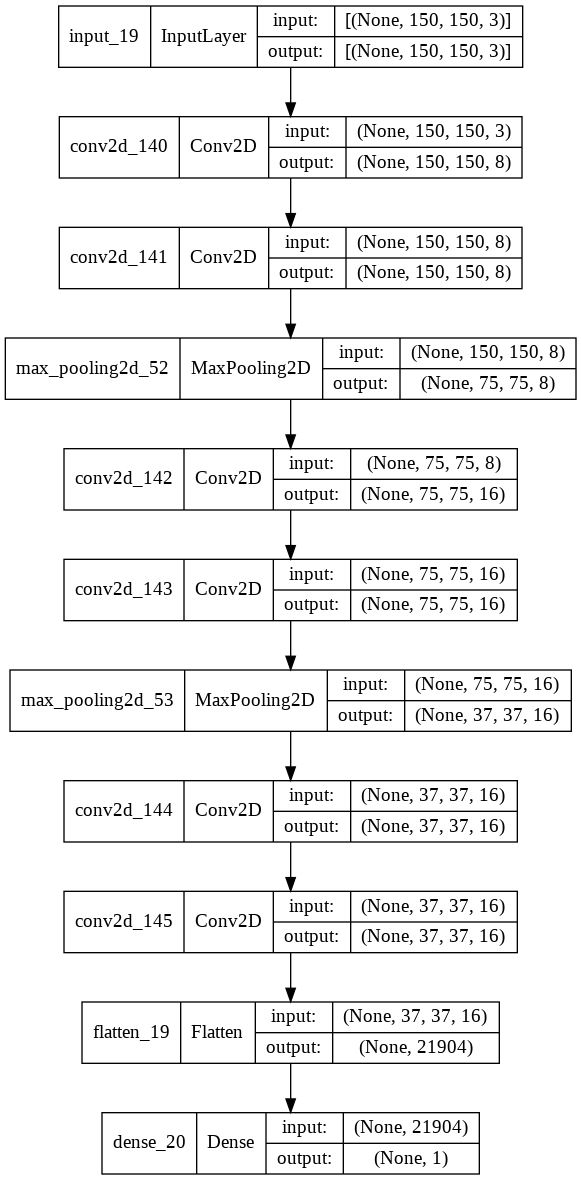

In [163]:
tf.keras.utils.plot_model(cnet, to_file="model.png", show_shapes = True)

In [164]:
disease_history = cnet.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
120/120 [==============================] - 299s 2s/step - loss: 0.4806 - auc_33: 0.5866 - val_loss: 0.4867 - val_auc_33: 0.6118
Epoch 2/10
120/120 [==============================] - 297s 2s/step - loss: 0.4622 - auc_33: 0.6161 - val_loss: 0.4734 - val_auc_33: 0.6081
Epoch 3/10
120/120 [==============================] - 298s 2s/step - loss: 0.4515 - auc_33: 0.6155 - val_loss: 0.4587 - val_auc_33: 0.6081
Epoch 4/10
120/120 [==============================] - 298s 2s/step - loss: 0.4572 - auc_33: 0.6088 - val_loss: 0.4511 - val_auc_33: 0.6028
Epoch 5/10
120/120 [==============================] - 297s 2s/step - loss: 0.4458 - auc_33: 0.6149 - val_loss: 0.4820 - val_auc_33: 0.6081
Epoch 6/10
120/120 [==============================] - 298s 2s/step - loss: 0.4426 - auc_33: 0.6130 - val_loss: 0.4498 - val_auc_33: 0.6128
Epoch 7/10
120/120 [==============================] - 298s 2s/step - loss: 0.4317 - auc_33: 0.6199 - val_loss: 0.4503 - val_auc_33: 0.6148
Epoch 8/10
120/120 [=======

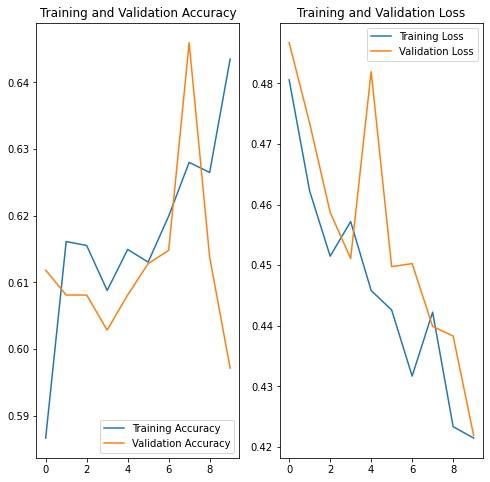

In [178]:
auc = disease_history.history['auc_33']
val_auc = disease_history.history['val_auc_33']
loss = disease_history.history['loss']
val_loss=disease_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training Accuracy')
plt.plot(epochs_range, val_auc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Classification for All the Labels

In [64]:
train_df = pd.read_csv('Training_Set/Training_Set/RFMiD_Training_Labels.csv')
val_df = pd.read_csv('Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df = pd.read_csv('Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

In [107]:
train_df['img_path'] = [f'Training_Set/Training_Set/Training/{id}.png' for id in train_df['ID']]
val_df['img_path'] = [f'Evaluation_Set/Evaluation_Set/Validation/{id}.png' for id in val_df['ID']]
test_df['img_path'] = [f'Test_Set/Test_Set/Test/{id}.png' for id in test_df['ID']]

In [66]:
train_df = train_df.drop(labels=['ID'],axis=1)

In [67]:
train_df = train_df.drop(labels=['Disease_Risk','ODPM', 'HR'], axis=1)
val_df = val_df.drop(labels=['ID', 'Disease_Risk', 'ODPM', 'HR'], axis=1)
test_df = test_df.drop(labels=['ID', 'Disease_Risk', 'ODPM', 'HR'], axis=1)

In [68]:
train_df.columns

Index(['DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'ERM', 'LS', 'MS',
       'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST', 'AION', 'PT',
       'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS', 'CB', 'PRH',
       'MNF', 'CRAO', 'TD', 'CME', 'PTCR', 'CF', 'VH', 'MCA', 'VS', 'BRAO',
       'PLQ', 'HPED', 'CL', 'img_path'],
      dtype='object')

In [69]:
Y_train = list(train_df.drop(['img_path'], axis=1).columns)
Y_val = list(val_df.drop(['img_path'], axis=1).columns)
Y_test = list(test_df.drop(['img_path'], axis=1).columns)
unq_disease = len(Y_train)
print(unq_disease)

43


## Data Augmentation
In tensorflow, we can pre-process images to extend the given dataset. Some slight transformation such as rescaling, transition, rotation, zittering (in color or brightness) don't change the information in the image that much. It is called **data augmentation**. In tensorflow, there is a method named **tf.keras.preprocessing.image.ImageDataGenerator** which generates batches of tensor image data with real-time data augmentation.

In [70]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range=90,
                                                                brightness_range=[0, 0.1])
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [71]:
train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              x_col='img_path', 
                                              y_col=Y_train,
                                              target_size=(150,150),
                                              class_mode='raw',
                                              batch_size=16,
                                              shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df,
                                          x_col='img_path',
                                          y_col=Y_val,
                                          target_size=(150,150),
                                          class_mode='raw',
                                          batch_size=8)
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col=Y_test,
                                            target_size=(150,150),
                                            class_mode='raw')

Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


## Training and Evaluating Model

In [90]:
def CNet(inputs):
    # First convolution block
    x = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    d1_con = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    d1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d1_con)
    
    # Second convolution block
    d2 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d2_con = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d2_con)
    
    '''
    # Third convolution block
    d3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d3_con = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d3_con)
    
    # Fourth convolution block
    d4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d4_con = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d4_con)
    '''

    # Bottleneck layer
    b = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    b = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(b)
    
    # Flatten and output
    flat = tf.keras.layers.Flatten()(b)
    out = tf.keras.layers.Dense(units=unq_disease, activation='sigmoid')(flat)
    model = tf.keras.Model(inputs=[inputs], outputs=[out])
    return model

In [91]:
auc = tf.keras.metrics.AUC(multi_label=True,thresholds=[0,0.5])
aucpr = tf.keras.metrics.AUC(curve='PR',multi_label=True,thresholds=[0,0.5])
inputs = tf.keras.layers.Input(shape=(150,150,3))
cnet = CNet(inputs)
cnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc, aucpr])
cnet.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_92 (Conv2D)          (None, 150, 150, 8)       224       
                                                                 
 conv2d_93 (Conv2D)          (None, 150, 150, 8)       584       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 75, 75, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 75, 75, 16)        1168      
                                                                 
 conv2d_95 (Conv2D)          (None, 75, 75, 16)        2320      
                                                           

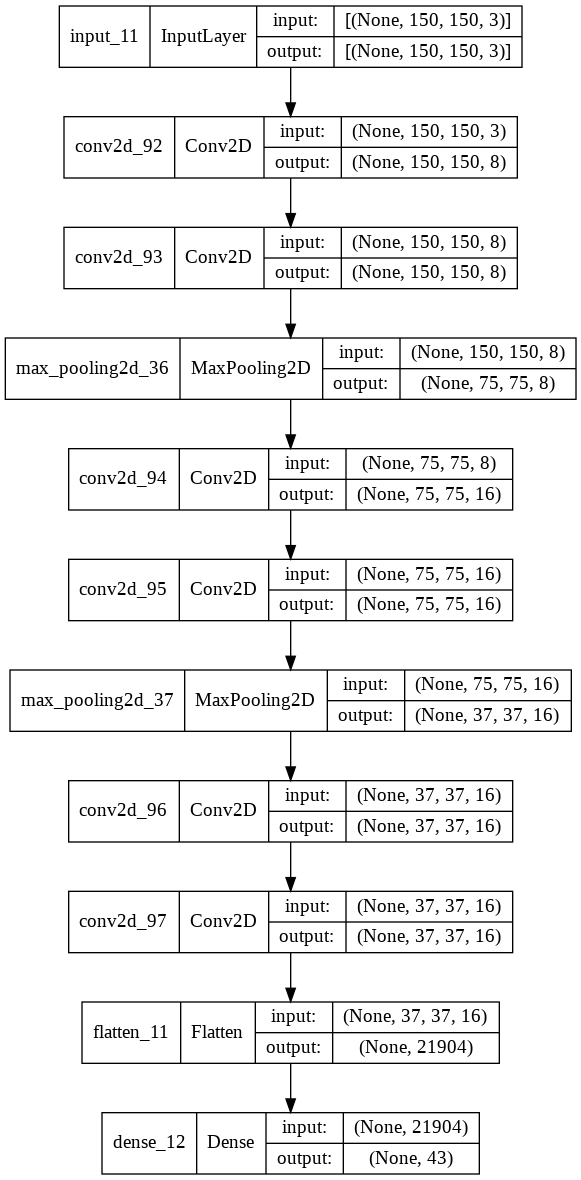

In [92]:
tf.keras.utils.plot_model(cnet, to_file="model.png", show_shapes = True)

In [93]:
history = cnet.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
120/120 [==============================] - 314s 3s/step - loss: 0.1113 - auc_20: 0.4999 - auc_21: 0.0251 - val_loss: 0.2205 - val_auc_20: 0.4419 - val_auc_21: 0.0251
Epoch 2/10
120/120 [==============================] - 310s 3s/step - loss: 0.0923 - auc_20: 0.5000 - auc_21: 0.0251 - val_loss: 0.1790 - val_auc_20: 0.4419 - val_auc_21: 0.0251
Epoch 3/10
120/120 [==============================] - 311s 3s/step - loss: 0.0916 - auc_20: 0.5000 - auc_21: 0.0251 - val_loss: 0.2138 - val_auc_20: 0.4455 - val_auc_21: 0.0270
Epoch 4/10
120/120 [==============================] - 311s 3s/step - loss: 0.0911 - auc_20: 0.5002 - auc_21: 0.0254 - val_loss: 0.1784 - val_auc_20: 0.4464 - val_auc_21: 0.0292
Epoch 5/10
120/120 [==============================] - 310s 3s/step - loss: 0.0902 - auc_20: 0.5005 - auc_21: 0.0258 - val_loss: 0.1465 - val_auc_20: 0.4453 - val_auc_21: 0.0298
Epoch 6/10
120/120 [==============================] - 311s 3s/step - loss: 0.0898 - auc_20: 0.5011 - auc_21: 0.0266

In [88]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(150, 150, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(unq_disease)
])

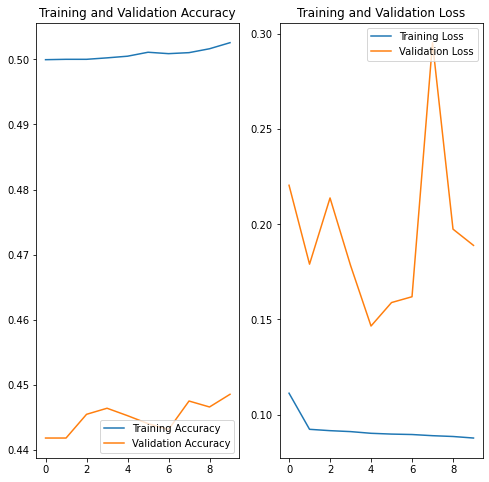

In [179]:
auc = history.history['auc_20']
val_auc = history.history['val_auc_20']
loss = history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training Accuracy')
plt.plot(epochs_range, val_auc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [94]:
evaluation = cnet.evaluate(test_gen)

20/20 [==============================] - 84s 4s/step - loss: 0.1678 - auc_20: 0.4142 - auc_21: 0.0321
